# Grid-World

**Recursive Reward Aggregation**  
Yuting Tang, Yivan Zhang, Johannes Ackermann, Yu-Jie Zhang, Soichiro Nishimori, Masashi Sugiyama  
Reinforcement Learning Conference 2025  
[[OpenReview]](https://openreview.net/forum?id=13lUcKpWy8)


## Overview

This notebook demonstrates the principle of **recursive reward aggregation** in a simple grid-world environment.

In standard **reinforcement learning** (RL), agents are usually trained to maximize the _discounted sum_ of rewards.
To control an agent's behavior, we typically modify its reward function.
But what if we didn't change the rewards themselves, and instead changed how we aggregate them over time?
That's the idea we'll explore here.
By generalizing the Bellman equation, we can describe a wide range of reward aggregation strategies in a unified way.

To make this concrete, we'll build a small **grid-world** environment and train agents using a minimal implementation of **Q-learning**.
By experimenting with different aggregation functions, such as $\max$, $\min$, and $\operatorname{mean}$, we'll see how each one shapes the agent's behavior in its own way, all without modifying the reward signal.
This highlights the expressive power of recursive aggregation and its potential as a flexible tool for _behavior alignment_ in RL.

Everything is self-contained and uses only Python’s standard library (plus `matplotlib` for plots), so you can run this notebook as-is.


In [1]:
import os
from pathlib import Path

fig_path = Path("figures")
os.makedirs(fig_path, exist_ok=True)

## Typing

We define the core elements of the grid-world environment as follows:

- `State` represents a grid cell, identified by its `(x, y)` coordinates.
  Mathematically, a `State` instance corresponds to an element of the set $S$ of states.

- `Action` is an enumeration of four cardinal movements: up, down, left, and right.
  This corresponds to the set $A$ of actions.

- `Reward` is a scalar value (`float`) assigned to each state-action pair, representing the immediate feedback received by the agent.
  This is the set $R$ of rewards.

- `Statistic` is a type variable representing the internal accumulator of a recursive aggregation function, which processes rewards over time.
  We'll define it later.


In [2]:
import enum
from dataclasses import dataclass
from typing import Callable, TypeVar, Union

In [3]:
@dataclass(frozen=True)
class State:
    x: int
    y: int


class Action(enum.Enum):
    UP = enum.auto()
    DOWN = enum.auto()
    LEFT = enum.auto()
    RIGHT = enum.auto()


Reward = float
Statistic = TypeVar("Statistic")

We define **right** and **down** as the positive directions.


In [4]:
num_actions = len(Action)

# Directions for movement in the grid
directions = {
    Action.UP: (0, -1),
    Action.DOWN: (0, 1),
    Action.LEFT: (-1, 0),
    Action.RIGHT: (1, 0),
}

# Directions for visualization of actions in the grid
triangle_directions = {
    Action.UP: ((-1, -1), (1, -1)),
    Action.DOWN: ((-1, 1), (1, 1)),
    Action.LEFT: ((-1, -1), (-1, 1)),
    Action.RIGHT: ((1, -1), (1, 1)),
}

## Helper functions

In [5]:
import random

random.seed(42)

In [6]:
def dict_argmax(d: dict[Action, Reward]) -> Action:
    """
    Return the action with the maximum value in the dictionary.
    If there are multiple actions with the same maximum value, return one of them randomly.
    """
    max_value = max(d.values())
    max_actions = [action for action, value in d.items() if value == max_value]
    return random.choice(max_actions)


def nested_map(d: dict, f: Callable[[Statistic], Reward]) -> dict:
    if isinstance(d, dict):
        return {k: nested_map(v, f) for k, v in d.items()}
    else:
        return f(d)

## Environment

The `Grid` class defines the **Markov decision process** (MDP) dynamics through the method `step(action)`, which implements a **transition function** $\mathrm{p}: S \times A \to S$ as well as a **reward function** $\mathrm{r}: S \times A \to R$.

At a `state`, given an `action`:

- if the move is valid, the agent moves to the new state and receives `reach_reward.get(state, 0.0)`;
- if the move is invalid (off-grid), the agent remains in place and receives `boundary_reward`.

Terminal states are checked explicitly.
When the agent reaches a terminal state, `step` returns `None`, signaling the end of an episode.

Note that the return type of `step` is `Union[None, tuple[Reward, State]]`, which corresponds to the type $\{*\} + R \times S$ (see Section 2.2).
`None` represents the singleton set $\{*\}$ and signals that the current state is terminal.
Otherwise `step` returns `(reward, state)` $\in R \times S$.


In [7]:
class Grid:
    def __init__(
        self,
        width: int,
        height: int,
        reach_reward: dict[State, Reward],
        boundary_reward: Reward,
        initial_state: State,
        terminal_states: list[State],
    ):
        # Parameters
        self.width = width
        self.height = height
        self.reach_reward = reach_reward
        self.boundary_reward = boundary_reward
        self.initial_state = initial_state
        self.terminal_states = terminal_states

        # State
        self.state = initial_state

    def is_valid(self, state: State) -> bool:
        # Check if the state is within the grid boundaries
        return 0 <= state.x < self.width and 0 <= state.y < self.height

    def reset(self) -> State:
        # Reset the state to the initial state
        self.state = self.initial_state
        return self.state

    def step(self, action: Action) -> Union[None, tuple[Reward, State]]:
        if self.state in self.terminal_states:
            # If the current state is terminal, return None as a termination signal
            return None
        else:
            # If the current state is non-terminal, proceed with the action
            dx, dy = directions[action]
            next_state = State(self.state.x + dx, self.state.y + dy)

            if self.is_valid(next_state):
                # If the next state is valid, update the state and return the reward
                reward = self.reach_reward.get(next_state, 0.0)
                self.state = next_state
                return reward, self.state
            else:
                # If the next state is invalid, return the boundary reward and the current state
                return self.boundary_reward, self.state

Let's design a simple grid-world environment with hand-crafted rewards.
The rewards here are chosen to highlight how different aggregation functions induce distinct behaviors.


In [8]:
num_cols = 4
num_rows = 3

reach_reward = {
    State(0, 0): -5.0,
    State(0, 1): -3.0,
    State(0, 2): -2.0,
    State(1, 0): -4.0,
    State(1, 1): -6.0,
    State(1, 2): -2.0,
    State(2, 0): -1.0,
    State(2, 1): -7.0,
    State(2, 2): -2.0,
    State(3, 0): -2.0,
    State(3, 1): -1.0,
    State(3, 2): 10.0,
}

boundary_reward = -10.0

initial_state = State(0, 0)
terminal_states = [State(num_cols - 1, num_rows - 1)]

Next, let's verify the environment dynamics.

The code below exhaustively iterates over all state-action pairs, resets the grid to each state, applies each action, and records the resulting reward.

It collects:

1. A list of all non-terminal states.
2. A reward table `rewards` $: S \times A \to R$, represented as a nested dictionary `dict[State, dict[Action, Reward]]`.

We use Python’s `match ... case` syntax to handle the `None` return (for terminal states) and `(reward, next_state)` otherwise, based on the `Grid.step()` function.


In [9]:
non_terminal_states: list[State] = []
rewards: dict[State, dict[Action, Reward]] = {}  # State -> (Action -> Reward) ~ (State, Action) -> Reward

for i in range(num_cols):
    for j in range(num_rows):
        state = State(i, j)
        grid = Grid(
            width=num_cols,
            height=num_rows,
            reach_reward=reach_reward,
            boundary_reward=boundary_reward,
            initial_state=state,
            terminal_states=terminal_states,
        )
        for action in Action:
            grid.reset()
            match grid.step(action):
                case None:
                    print(f"{state} is terminal.")
                case (reward, next_state):
                    non_terminal_states.append(state)
                    rewards.setdefault(state, {})[action] = reward
                    print(f"{state} -> {action.name:<5} -> {next_state}: {reward}")

all_states = non_terminal_states + terminal_states

State(x=0, y=0) -> UP    -> State(x=0, y=0): -10.0
State(x=0, y=0) -> DOWN  -> State(x=0, y=1): -3.0
State(x=0, y=0) -> LEFT  -> State(x=0, y=0): -10.0
State(x=0, y=0) -> RIGHT -> State(x=1, y=0): -4.0
State(x=0, y=1) -> UP    -> State(x=0, y=0): -5.0
State(x=0, y=1) -> DOWN  -> State(x=0, y=2): -2.0
State(x=0, y=1) -> LEFT  -> State(x=0, y=1): -10.0
State(x=0, y=1) -> RIGHT -> State(x=1, y=1): -6.0
State(x=0, y=2) -> UP    -> State(x=0, y=1): -3.0
State(x=0, y=2) -> DOWN  -> State(x=0, y=2): -10.0
State(x=0, y=2) -> LEFT  -> State(x=0, y=2): -10.0
State(x=0, y=2) -> RIGHT -> State(x=1, y=2): -2.0
State(x=1, y=0) -> UP    -> State(x=1, y=0): -10.0
State(x=1, y=0) -> DOWN  -> State(x=1, y=1): -6.0
State(x=1, y=0) -> LEFT  -> State(x=0, y=0): -5.0
State(x=1, y=0) -> RIGHT -> State(x=2, y=0): -1.0
State(x=1, y=1) -> UP    -> State(x=1, y=0): -4.0
State(x=1, y=1) -> DOWN  -> State(x=1, y=2): -2.0
State(x=1, y=1) -> LEFT  -> State(x=0, y=1): -3.0
State(x=1, y=1) -> RIGHT -> State(x=2, y=1):

## Visualization

Let's visualize the environment.

In [10]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon

In [11]:
def get_fig_ax() -> tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(figsize=(2 * num_cols, 2 * num_rows))
    ax.set_aspect("equal")
    ax.set_xlim(-0.5, num_cols - 0.5)
    ax.set_ylim(-0.5, num_rows - 0.5)
    ax.invert_yaxis()  # Invert y-axis to match grid coordinates (down is positive direction)
    ax.set_axis_off()  # Hide the axes

    return fig, ax


def plot_state_action(ax: plt.Axes, state: State, action: Action, color, text: str = None, plot_arrow: bool = True):
    """
    Plot a state-action pair as a triangle in the grid.
    Args:
        ax: The matplotlib axes object to plot on.
        state: The state to plot.
        action: The action to plot.
        color: The color of the triangle.
        text: Optional text to display at the arrow tip.
        plot_arrow: Whether to plot an arrow for the action direction.
    """
    ((d1x, d1y), (d2x, d2y)) = triangle_directions[action]
    d3x, d3y = directions[action]
    v0 = (state.x, state.y)
    v1 = (state.x + 0.49 * d1x, state.y + 0.49 * d1y)
    v2 = (state.x + 0.49 * d2x, state.y + 0.49 * d2y)
    v3 = (state.x + 0.32 * d3x, state.y + 0.32 * d3y)

    # Plot the triangle, optionally with an arrow and text
    ax.add_patch(Polygon([v0, v1, v2], fc=color))
    if plot_arrow:
        ax.arrow(
            *v0,
            0.1 * d3x,
            0.1 * d3y,
            color="k",
            lw=2,
            head_width=0.1,
            head_length=0.05,
            zorder=10,
        )
    if text is not None:
        ax.text(*v3, text, color="k", fontsize=18, ha="center", va="center")


def plot_grid(ax: plt.Axes, q: dict[State, dict[Action, Reward]], plot_arrows: bool = True):
    """
    Plot the values for each state-action pair in a grid format.
    Args:
        ax: The matplotlib axes object to plot on.
        q: A state-action function.
        plot_arrows: Whether to plot arrows for the action(s) with the maximum value in each state.
    """

    # Color normalization and colormap
    vmin = min(min(v.values()) for v in q.values())
    vmax = max(max(v.values()) for v in q.values())
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mpl.colormaps["RdYlGn"]

    # Plot values for non-terminal states
    for state in non_terminal_states:
        state_vmax = max(q[state].values())
        for action, v in q[state].items():
            color = cmap(norm(v))
            plot_arrow = plot_arrows and (v == state_vmax)
            plot_state_action(ax, state, action, color, text=f"{v:.1f}", plot_arrow=plot_arrow)

    # Plot terminal states
    for state in terminal_states:
        for action in Action:
            color = cmap(1.0)
            plot_state_action(ax, state, action, color, plot_arrow=False)

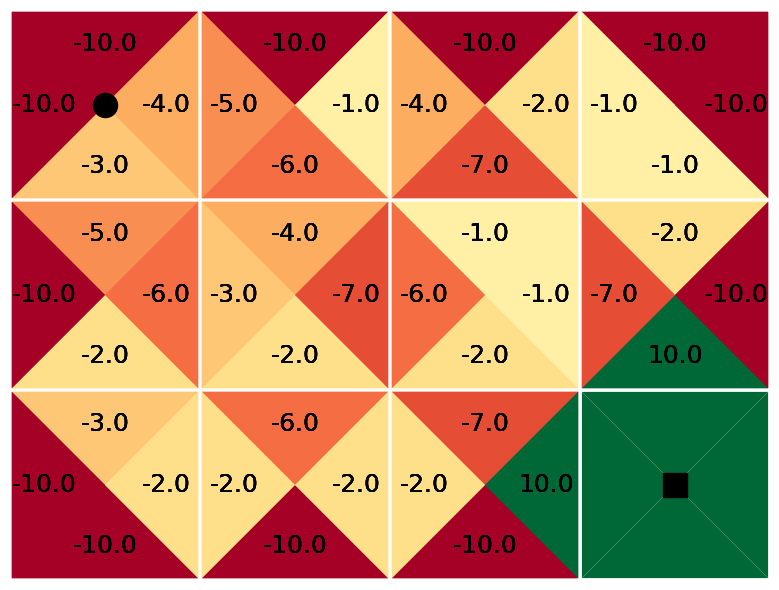

In [12]:
fig, ax = get_fig_ax()

# Plot the grid with state-action values
plot_grid(ax, rewards, plot_arrows=False)
# Plot initial and terminal states
ax.scatter(initial_state.x, initial_state.y, marker="o", color="k", s=300)
for state in terminal_states:
    ax.scatter(state.x, state.y, marker="s", color="k", s=300)

fig.tight_layout()
fig.savefig(fig_path / "grid_env.pdf")

## Aggregation functions

Now it's time to define the set $T$ of **statistics** (`Statistic`) and implement recursive reward aggregation.

Each recursive aggregation is specified by:

- an **initial value** $\mathrm{init} \in T$: the default value(s) of `Statistic` when a terminal state is reached
- an **update function** $\mathbin{\triangleright}: R \times T \to T$: how new rewards are folded into the statistic

The recursive statistic aggregation function $\mathrm{agg}: [R] \to T$ is defined as follows (see Section 3.1):

\begin{equation*}
\mathrm{agg}: [R] \to T
:=
\left\{
\begin{array}{ccl}
[] & \mapsto & \mathrm{init},
\\
r_{t:\Omega} & \mapsto & r_t \mathbin{\triangleright} \mathrm{agg}(r_{t+1:\Omega}),
\end{array}
\right.
\end{equation*}

Together with a **post-processing function** $\mathrm{post}: T \to R$, we obtain a **recursive reward aggregation** function.


### Example: length

The simplest recursive statistic counts the number of steps in a trajectory, regardless of reward values.

It can be used to compute the episode length or normalize other statistics (e.g., for mean or variance).


In [13]:
@dataclass(frozen=True)
class LengthStatistic:
    length: int = 0


def update_length(reward: Reward, statistic: LengthStatistic) -> LengthStatistic:
    return LengthStatistic(statistic.length + 1)


def post_length(statistic: LengthStatistic) -> float:
    return statistic.length

### Parameterized updates

Many aggregation functions involve a **discount factor** $\gamma \in [0, 1]$, which controls the contribution of future rewards relative to immediate ones.

A canonical example is the **discounted sum**, which can be defined recursively using the "discounted addition" $+_\gamma: R \times R \to R := [a, b \mapsto a + \gamma \cdot b]$.


In [14]:
@dataclass(frozen=True)
class SumStatistic:
    sum: Reward = 0.0


def update_discounted_sum(discount: float):
    def update(reward: Reward, statistic: SumStatistic) -> SumStatistic:
        return SumStatistic(reward + discount * statistic.sum)

    return update


def post_sum(statistic: SumStatistic) -> Reward:
    return statistic.sum

In [15]:
@dataclass(frozen=True)
class MinStatistic:
    min: Reward = float("inf")


def update_discounted_min(discount: float):
    def update(reward: Reward, statistic: MinStatistic) -> MinStatistic:
        return MinStatistic(min(reward, discount * statistic.min))

    return update


def post_min(statistic: MinStatistic) -> Reward:
    return statistic.min

In [16]:
@dataclass(frozen=True)
class MaxStatistic:
    max: float = float("-inf")


def update_discounted_max(discount: float):
    def update(reward: Reward, statistic: MaxStatistic) -> MaxStatistic:
        return MaxStatistic(max(reward, discount * statistic.max))

    return update


def post_max(statistic: MaxStatistic) -> Reward:
    return statistic.max

### Alternative updates

For a given type of statistic, different update rules can define different aggregation behaviors.

A notable example is the **log-sum-exp** function, which serves as a smooth approximation of the max function.


In [17]:
import math


def update_log_sum_exp(reward: Reward, statistic: MaxStatistic) -> MaxStatistic:
    return MaxStatistic(math.log(math.exp(reward) + math.exp(statistic.max)))

### Compositional statistics


In [18]:
@dataclass(frozen=True)
class MinMaxStatistic:
    min: Reward = float("inf")
    max: Reward = float("-inf")


def update_min_max(reward: Reward, statistic: MinMaxStatistic) -> MinMaxStatistic:
    return MinMaxStatistic(min=min(reward, statistic.min), max=max(reward, statistic.max))


def post_range(statistic: MinMaxStatistic) -> Reward:
    return statistic.max - statistic.min

### Parameterized post-processing


In [19]:
def post_min_max(lam: float = 1.0):
    # max - lam * range = lam * min + (1 - lam) * max
    def post(statistic: MinMaxStatistic) -> Reward:
        return lam * statistic.min + (1 - lam) * statistic.max

    return post

### Mean


In [20]:
@dataclass(frozen=True)
class LengthSumStatistic:
    length: int = 0
    sum: float = 0.0


def update_length_sum(reward: Reward, statistic: LengthSumStatistic) -> LengthSumStatistic:
    return LengthSumStatistic(length=statistic.length + 1, sum=statistic.sum + reward)


def post_mean(statistic: LengthSumStatistic) -> Reward:
    if statistic.length == 0:
        return 0.0
    else:
        return statistic.sum / statistic.length

### Variance


In [21]:
@dataclass(frozen=True)
class LengthSumSquareStatistic:
    length: int = 0
    sum: Reward = 0.0
    sum_square: Reward = 0.0


def update_length_sum_square(reward: Reward, statistic: LengthSumSquareStatistic) -> LengthSumSquareStatistic:
    return LengthSumSquareStatistic(
        length=statistic.length + 1,
        sum=statistic.sum + reward,
        sum_square=statistic.sum_square + reward**2,
    )


def post_variance(statistic: LengthSumSquareStatistic) -> Reward:
    if statistic.length == 0:
        return 0.0
    else:
        return statistic.sum_square / statistic.length - (statistic.sum / statistic.length) ** 2

### Non-uniqueness of update function and post-processing function


In [22]:
@dataclass(frozen=True)
class LengthMeanVarianceStatistic:
    length: int = 0
    mean: Reward = 0.0
    variance: Reward = 0.0


def update_welford_variance(reward: Reward, statistic: LengthMeanVarianceStatistic) -> LengthMeanVarianceStatistic:
    return LengthMeanVarianceStatistic(
        length=statistic.length + 1,
        mean=(statistic.mean * statistic.length + reward) / (statistic.length + 1),
        variance=statistic.variance + statistic.length / (statistic.length + 1) * (reward - statistic.mean) ** 2,
    )


def post_welford_variance(statistic: LengthMeanVarianceStatistic) -> Reward:
    return statistic.variance

## Q-learning


Next, we implement the Q-learning algorithm.

This algorithm learns a value for each state-action pair by repeatedly updating it based on the observed rewards and estimated future returns/statistics.
In our case, we'll modify the update rule to reflect different reward aggregation strategies.

Initialization:

In [23]:
def get_statistic_function(
    statistic: Statistic,
) -> dict[State, dict[Action, Statistic]]:
    return {state: {action: statistic for action in Action} for state in all_states}

$\epsilon$-greedy exploratioin strategy:

In [24]:
def epsilon_greedy(values: dict[Action, Reward], epsilon: float = 0.3) -> Action:
    """
    Choose an action using epsilon-greedy strategy.
    Args:
        values: A dictionary mapping actions to their values.
        epsilon: The probability of choosing a random action.
    Returns:
        action: The chosen action, either random or the one with the maximum value.
    """
    if random.uniform(0, 1) < epsilon:
        # Choose a random action with probability epsilon
        action = random.choice(list(Action))
    else:
        # Choose the action with the maximum value (dictionary argmax)
        action = dict_argmax(values)
    return action

**Core** (see Definition D.9 Bellman optimality operator and Appendix G.1):

In [25]:
def update_statistics(
    statistics: dict[State, dict[Action, Statistic]],
    state: State,
    action: Action,
    reward: Reward,
    next_state: State,
    update: Callable[[Reward, Statistic], Statistic],
    post: Callable[[Statistic], Reward],
):
    """
    Update state-action statistic function using the reward received after taking an action in a given state.
    Args:
        statistics: State-action statistic function.
        state: The current state.
        action: The action taken in the current state.
        reward: The reward received after taking the action.
        next_state: The next state after taking the action.
        update: A function to update the statistic with the reward.
        post: A function to convert the statistic to a reward value.
    """
    next_values = {next_action: post(update(reward, statistics[next_state][next_action])) for next_action in Action}
    optimal_action = dict_argmax(next_values)
    statistics[state][action] = update(reward, statistics[next_state][optimal_action])

## Training


In [26]:
num_episodes = 10_000

grid = Grid(
    width=num_cols,
    height=num_rows,
    reach_reward=reach_reward,
    boundary_reward=boundary_reward,
    initial_state=initial_state,
    terminal_states=terminal_states,
)

In [27]:
def train_one_episode(
    grid: Grid,
    statistics: dict[State, dict[Action, Statistic]],
    update: Callable[[Reward, Statistic], Statistic],
    post: Callable[[Statistic], Reward],
):
    state = grid.reset()
    while True:
        action = epsilon_greedy(nested_map(statistics[state], post))
        match grid.step(action):
            case None:
                # If the current state is terminal, break the loop
                break
            case (reward, next_state):
                # If the current state is non-terminal, update the statistics
                update_statistics(statistics, state, action, reward, next_state, update, post)
                state = next_state

## Run

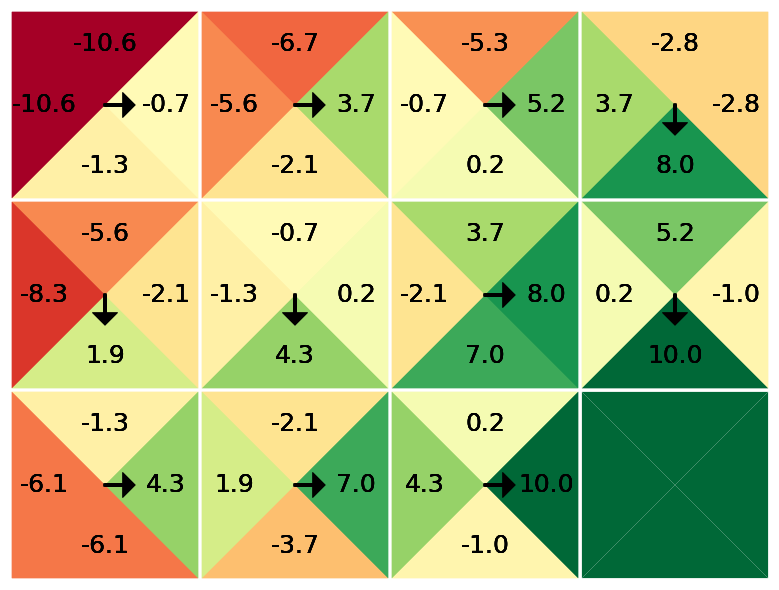

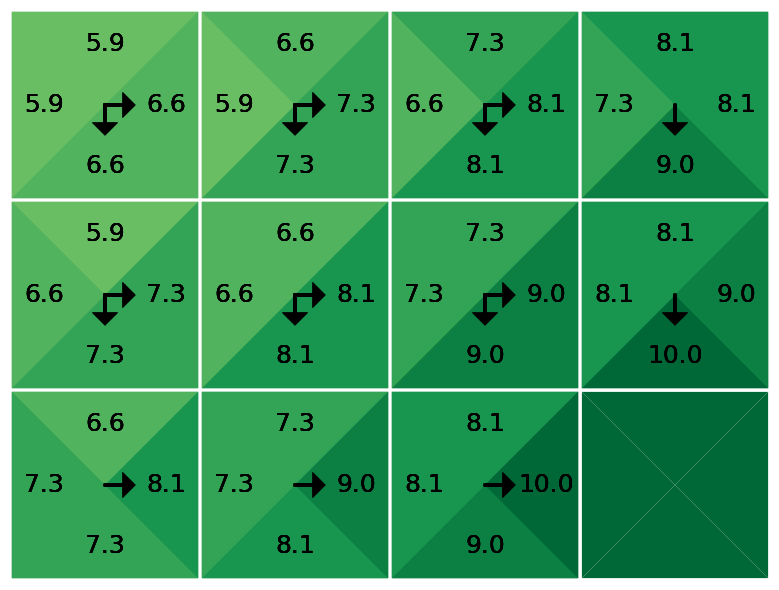

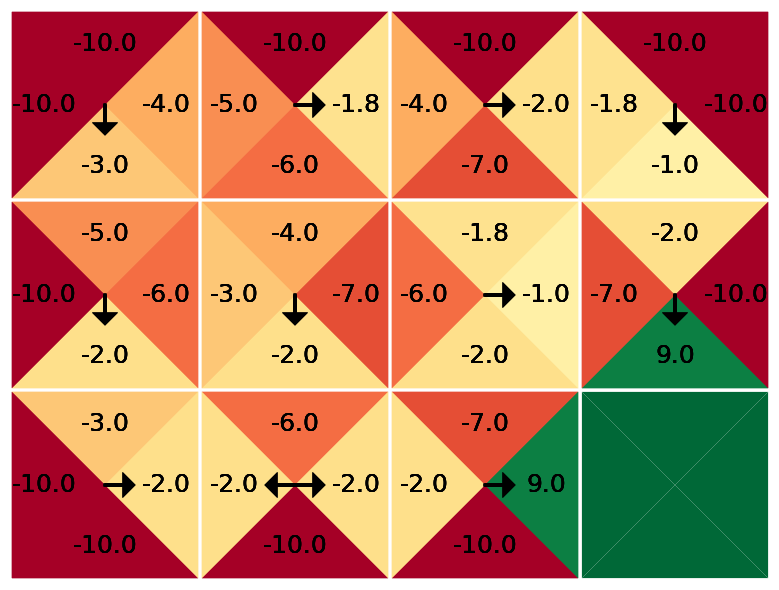

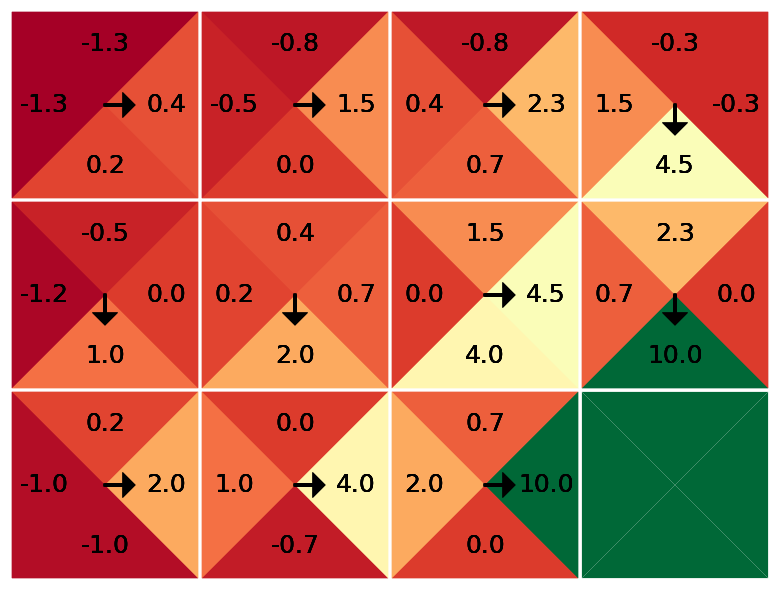

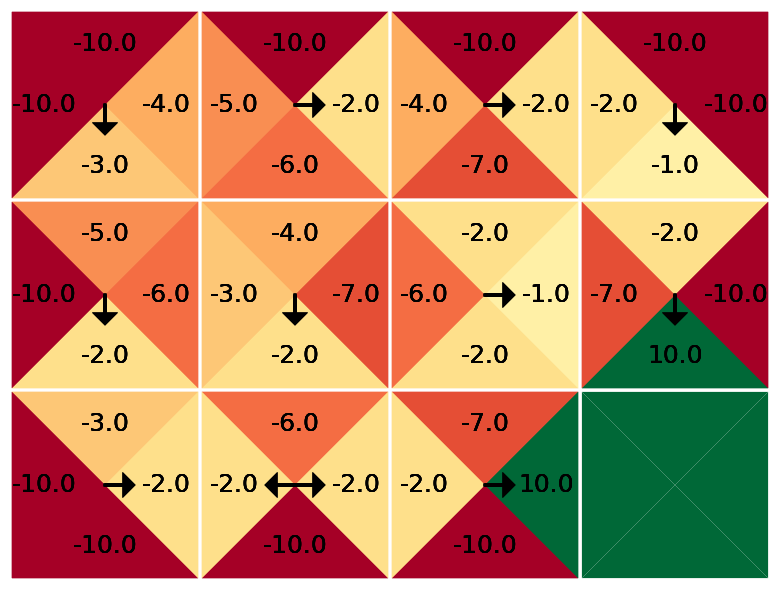

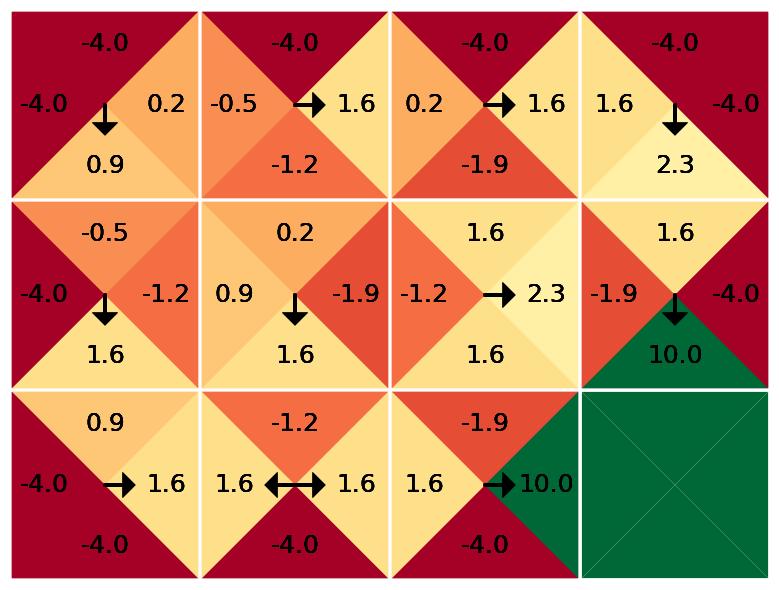

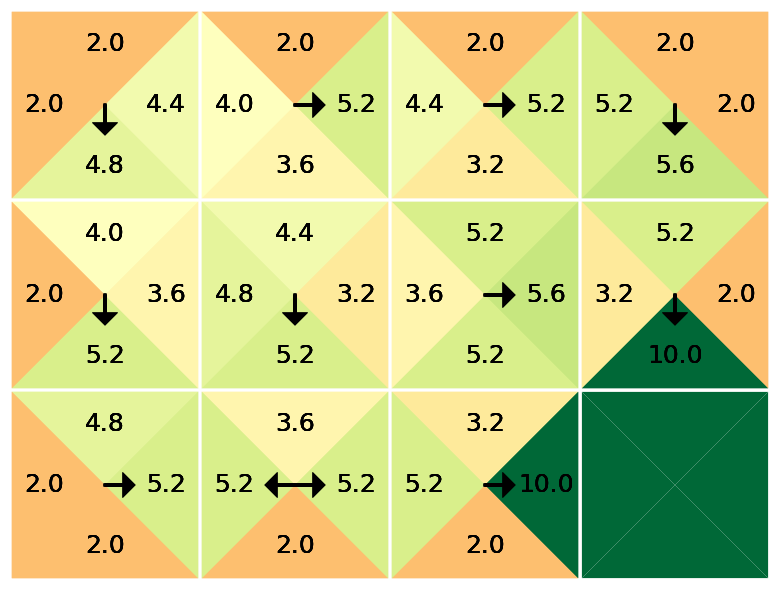

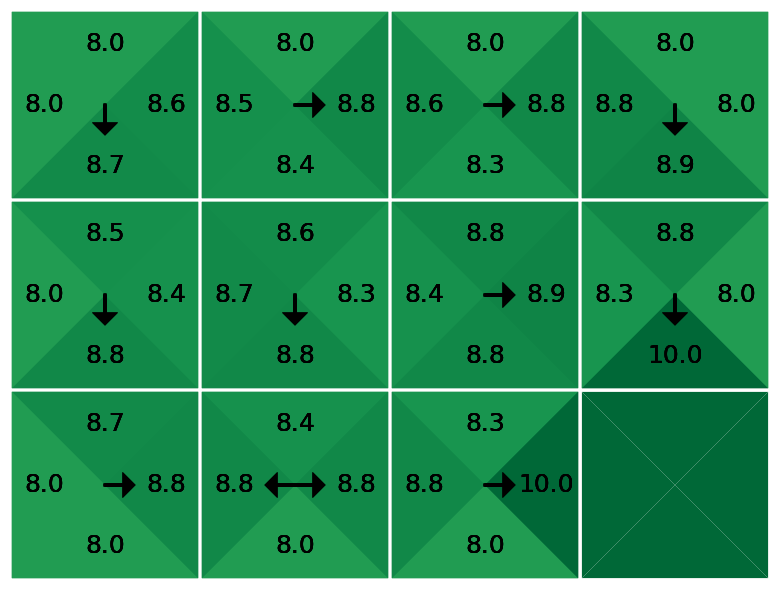

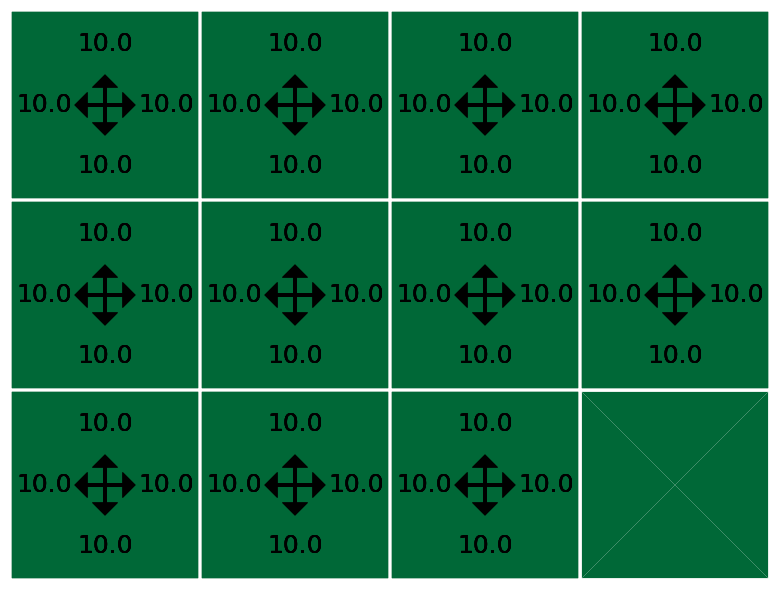

In [28]:
for name, init, update, post in [
    ("dsum", SumStatistic(), update_discounted_sum(discount=0.9), post_sum),
    ("dmax", MaxStatistic(-10.0), update_discounted_max(discount=0.9), post_max),
    ("dmin", MinStatistic(10.0), update_discounted_min(discount=0.9), post_min),
    ("mean", LengthSumStatistic(), update_length_sum, post_mean),
    ("min", MinStatistic(10.0), update_discounted_min(discount=1.0), post_min),
    (
        "0.7min+0.3max",
        MinMaxStatistic(10.0, -10.0),
        update_min_max,
        post_min_max(lam=0.7),
    ),
    (
        "0.4min+0.6max",
        MinMaxStatistic(10.0, -10.0),
        update_min_max,
        post_min_max(lam=0.4),
    ),
    (
        "0.1min+0.9max",
        MinMaxStatistic(10.0, -10.0),
        update_min_max,
        post_min_max(lam=0.1),
    ),
    ("max", MaxStatistic(-10.0), update_discounted_max(discount=1.0), post_max),
]:
    statistics = get_statistic_function(init)

    for _ in range(num_episodes):
        train_one_episode(grid, statistics, update, post)

    values = nested_map(statistics, post)
    fig, ax = get_fig_ax()
    plot_grid(ax, values)

    fig.tight_layout()
    fig.savefig(fig_path / f"grid_{name}.pdf")